In [18]:
import os
from pathlib import Path
import glob

import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
import geoutils as gu
import xdem
from pprint import pprint
import altair as alt

## Inputs

In [19]:
TO_DROP = ['1970_09_29', '1977_09_27', '1990_09_05']
TO_COREGISTER = False
SAVE_DDEMS = False
erosion_by_date = True
INTERPOLATE = True

erosion_polygon_file = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/erosion.geojson"

glacier_polygons_file = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/glaciers.geojson"
reference_dem_date = datetime(2015, 9, 1)

dems_path = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems"
dods_output_path = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dods"
valley_bounds_file = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/valley_bounds.geojson"

#format of the dates, how dem files are named and also how dates are written in the erosion_polygon_file shapefile in the `start_time` and `end_time` columns
strip_time_format = "%Y_%m_%d"

plot_output_dir = "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/plots/"

uncertainty_file = "uncertainty_deming.pcl"

# Uncertainty parameters file - generated with accompanying deming_uncertainty.ipynb notebook
uncertainty_df = pd.read_pickle(uncertainty_file)
uncertainty_df.head()

,Interval,NMAD,Mean,RMSE,Range,Sill,Range (double-range),Sill (double-range),Start Date,End Date
0,"(1970-09-29, 1979-10-06]",0.306945,0.003071,0.885758,9.098983,0.117426,7.925989,0.098882,1970-09-29,1979-10-06
1,"(1979-10-06, 1991-09-09]",0.374994,-0.093429,0.567138,14.507594,0.284764,11.098325,0.235859,1979-10-06,1991-09-09
2,"(1991-09-09, 2013-09-13]",0.532447,-0.107227,0.659183,27.685824,0.381261,22.918850,0.333374,1991-09-09,2013-09-13
3,"(2013-09-13, 2015-09-01]",0.389472,0.060100,2.726016,14.355707,0.266392,13.008689,0.240264,2013-09-13,2015-09-01
4,"(2015-09-01, 2019-10-11]",0.393363,-0.697468,6.133268,27.804843,0.220946,214.417687,0.060802,2015-09-01,2019-10-11


In [20]:
if not os.path.exists(plot_output_dir):
    os.makedirs(plot_output_dir, exist_ok=True)

## Get DEM file paths

In [21]:
dem_fn_list = glob.glob(os.path.join(dems_path, "*.tif"))
dem_fn_list = sorted(dem_fn_list)
dem_fn_list = [f for f in dem_fn_list if Path(f).stem not in TO_DROP]
dem_fn_list

['/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems/1979_10_06.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems/1991_09_09.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems/2013_09_13.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems/2015_09_01.tif',
 '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems/2019_10_11.tif']

In [22]:
datetimes = [datetime.strptime(Path(f).stem, strip_time_format) for f in dem_fn_list]
datetimes

[datetime.datetime(1979, 10, 6, 0, 0),
 datetime.datetime(1991, 9, 9, 0, 0),
 datetime.datetime(2013, 9, 13, 0, 0),
 datetime.datetime(2015, 9, 1, 0, 0),
 datetime.datetime(2019, 10, 11, 0, 0)]

## Open valley bounds polygons

In [23]:
valley_bounds = gu.Vector(valley_bounds_file)
valley_bounds_vect = valley_bounds.query("name == 'Deming' and purpose=='analysis'")
large_valley_bounds_vect = valley_bounds.query("name == 'Deming' and purpose=='analysis large'")
display(valley_bounds_vect.ds)
display(large_valley_bounds_vect.ds)

,id,name,purpose,geometry
0,None,Deming,analysis,"POLYGON ((584887.675 5398998.394, 584891.229 5..."


,id,name,purpose,geometry
2,None,Deming,analysis large,"POLYGON ((584881.761 5397538.950, 584881.761 5..."


## Create DEMCollections

In [24]:
demcollection = xdem.DEMCollection.from_files(
    dem_fn_list, 
    datetimes, 
    reference_dem_date, 
    large_valley_bounds_vect, 
    2
)

## Plot DEMs

/home/elilouis/xdem/xdem/terrain.py:378: RuntimeWarning: invalid value encountered in remainder
  terrain_attributes["aspect"] = (


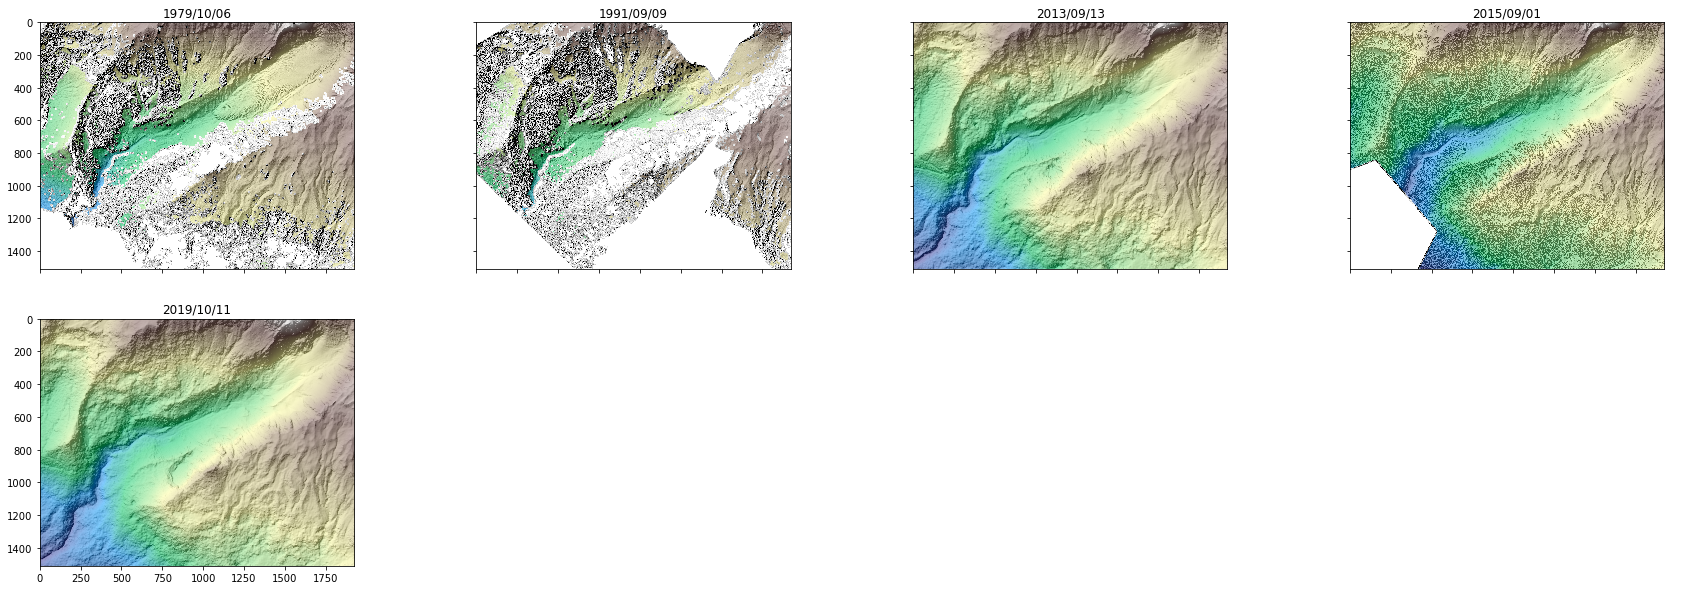

In [25]:
fig, axes = demcollection.plot_dems(hillshade=True, interpolation = "none", figsize=(30, 10))
fig.savefig(os.path.join(plot_output_dir, "dem_gallery.png"))
plt.show()

In [26]:
# fig, axes = demcollection_large.plot_dems(hillshade=True, interpolation = "none", figsize=(30, 10))
# fig.savefig(os.path.join(plot_output_dir, "dem_gallery_large.png"))
# plt.show()

## Coregister DEMs or Do Not

In [27]:

if TO_COREGISTER:
    for i in range(0, len(demcollection.dems)-1):
        early_dem = demcollection.dems[i]
        late_dem = demcollection.dems[i+1]

        nuth_kaab = xdem.coreg.NuthKaab()
        # Order with the future as reference
        nuth_kaab.fit(late_dem.data, early_dem.data, transform=late_dem.transform)

        # Apply the transformation to the data (or any other data)
        aligned_ex = nuth_kaab.apply(early_dem.data, transform=early_dem.transform)

        print(F"For DEM {early_dem.datetime}, transform is {nuth_kaab.to_matrix()}")

        early_dem.data = np.expand_dims(aligned_ex, axis=0)

## Subtract DEMs/Create DoDs

In [28]:
_ = demcollection.subtract_dems_intervalwise()
# _ = demcollection_large.subtract_dems_intervalwise()

## Prepare erosion polygons

### Load erosion polygons

In [29]:
erosion_vector = gu.Vector(erosion_polygon_file)
erosion_vector.ds = erosion_vector.ds.to_crs(demcollection.reference_dem.crs)
erosion_vector.ds.head(3)

,id,mass_wasted_raw_dod,mass_wasted_masked_forest,name,fluvial,type,geometry
0,None,None,None,Deming,True,fluvial,"POLYGON ((583716.500 5399683.471, 583623.638 5..."
1,None,None,None,None,None,hillslope,"POLYGON ((583513.278 5399364.160, 583513.560 5..."
2,None,None,None,None,None,hillslope,"POLYGON ((582659.399 5399227.695, 582651.352 5..."


### Mask Glaciers

Masking glaciers only applies if not erosion_by_date

For each dDEM time interval, get the two relevant glacier polygons, and subtract them from each erosion polygon, so that each erosion polygon multiplies to become one erosion polygon per time interval

In [30]:
glaciers_gdf = gpd.read_file(glacier_polygons_file).to_crs(demcollection.reference_dem.crs)
glaciers_gdf['date'] = glaciers_gdf['year'].apply(lambda x: datetime.strptime(x, strip_time_format))

new_erosion_gdf = []

for ddem in demcollection.ddems:
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([ddem.interval.left, ddem.interval.right])]
    assert len(relevant_glacier_polygons) == 2
    differenced_geoms = erosion_vector.ds.geometry.apply(
        lambda geom: geom.difference(
            relevant_glacier_polygons.geometry.iloc[0]
        ).difference(relevant_glacier_polygons.geometry.iloc[1])
    )
    new_erosion_gdf.append(
        gpd.GeoDataFrame(
            {
                'geometry': differenced_geoms,
                'type': erosion_vector.ds['type'],
                'interval': np.full(
                    len(differenced_geoms),
                    ddem.interval
                )
            }
        )
    )
new_erosion_gdf = pd.concat(new_erosion_gdf)

erosion_vector.ds = new_erosion_gdf

### Split erosion vector into dictionary that organizes erosion polygons by a pd.Interval(start_date, end_Date)

We do this so that DEMCollection.get_dv_series assigns the correct polygons to the correct dDEMs

In [33]:
erosion_vector.ds

,geometry,type,interval
0,"POLYGON ((583168.792 5399387.281, 583159.240 5...",fluvial,"(1979-10-06, 1991-09-09]"
1,"MULTIPOLYGON (((583511.689 5399358.800, 583511...",hillslope,"(1979-10-06, 1991-09-09]"
2,"POLYGON ((582648.077 5399231.426, 582642.627 5...",hillslope,"(1979-10-06, 1991-09-09]"
0,"POLYGON ((583262.311 5399421.045, 583251.204 5...",fluvial,"(1991-09-09, 2013-09-13]"
1,"MULTIPOLYGON (((583511.689 5399358.800, 583511...",hillslope,"(1991-09-09, 2013-09-13]"
2,"POLYGON ((582648.077 5399231.426, 582642.627 5...",hillslope,"(1991-09-09, 2013-09-13]"
0,"POLYGON ((583633.720 5399560.362, 583602.412 5...",fluvial,"(2013-09-13, 2015-09-01]"
1,"MULTIPOLYGON (((583511.689 5399358.800, 583511...",hillslope,"(2013-09-13, 2015-09-01]"
2,"POLYGON ((582648.077 5399231.426, 582642.627 5...",hillslope,"(2013-09-13, 2015-09-01]"
0,"POLYGON ((583724.459 5399587.956, 583674.579 5...",fluvial,"(2015-09-01, 2019-10-11]"


In [34]:
start_date_to_gfd = dict(list(erosion_vector.ds.groupby("interval")))
start_date_to_gfd = dict({(key, gu.Vector(gdf)) for key, gdf in start_date_to_gfd.items()})
demcollection.outlines = start_date_to_gfd

Plot erosion geoms by date

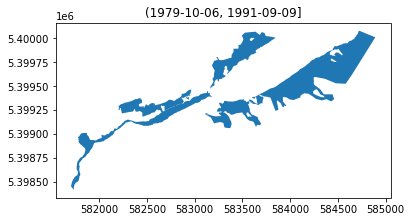

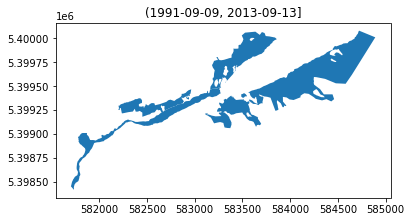

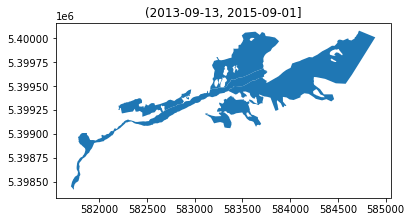

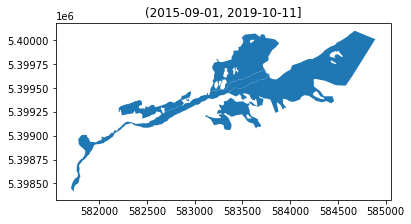

In [35]:
grouped_erosion_vector_gdf = erosion_vector.ds.groupby('interval')
for tuple in list(grouped_erosion_vector_gdf):
    interval = tuple[0]
    gdf = tuple[1]
    gdf.plot()
    plt.gca().set_title(str(interval))
    plt.show()

## Plot DoDs

In [36]:
demcollection.ddems[0].crs

CRS.from_epsg(32610)

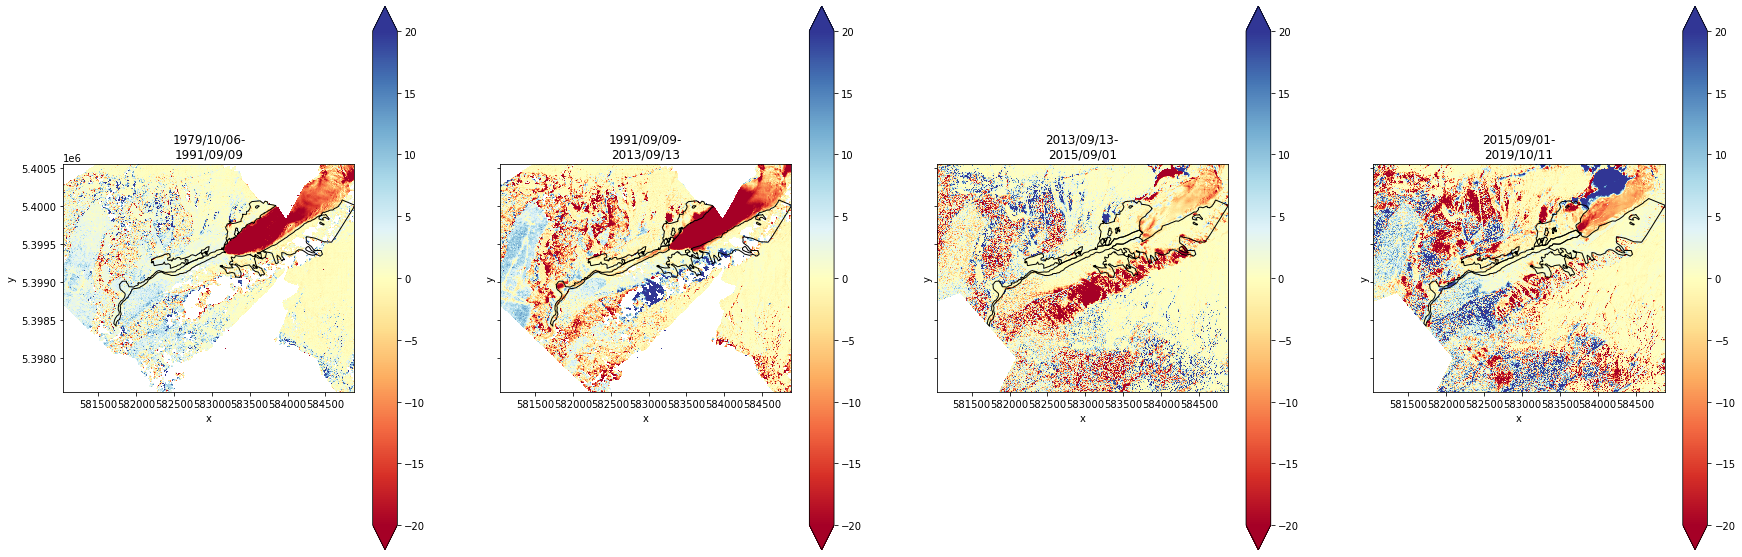

In [37]:
fig, axes = demcollection.plot_ddems(
    figsize=(30, 10), vmin=-20, vmax=20, 
    interpolation = "none", 
    plot_outlines=True
)
fig.savefig(os.path.join(plot_output_dir, "dod_gallery.png"))
plt.show()

## Interpolate

In [38]:
if INTERPOLATE:
    interpolated_ddems = demcollection.interpolate_ddems(max_search_distance=50)
    demcollection.set_ddem_filled_data()

option 2A
option 2A
option 2A
option 2A


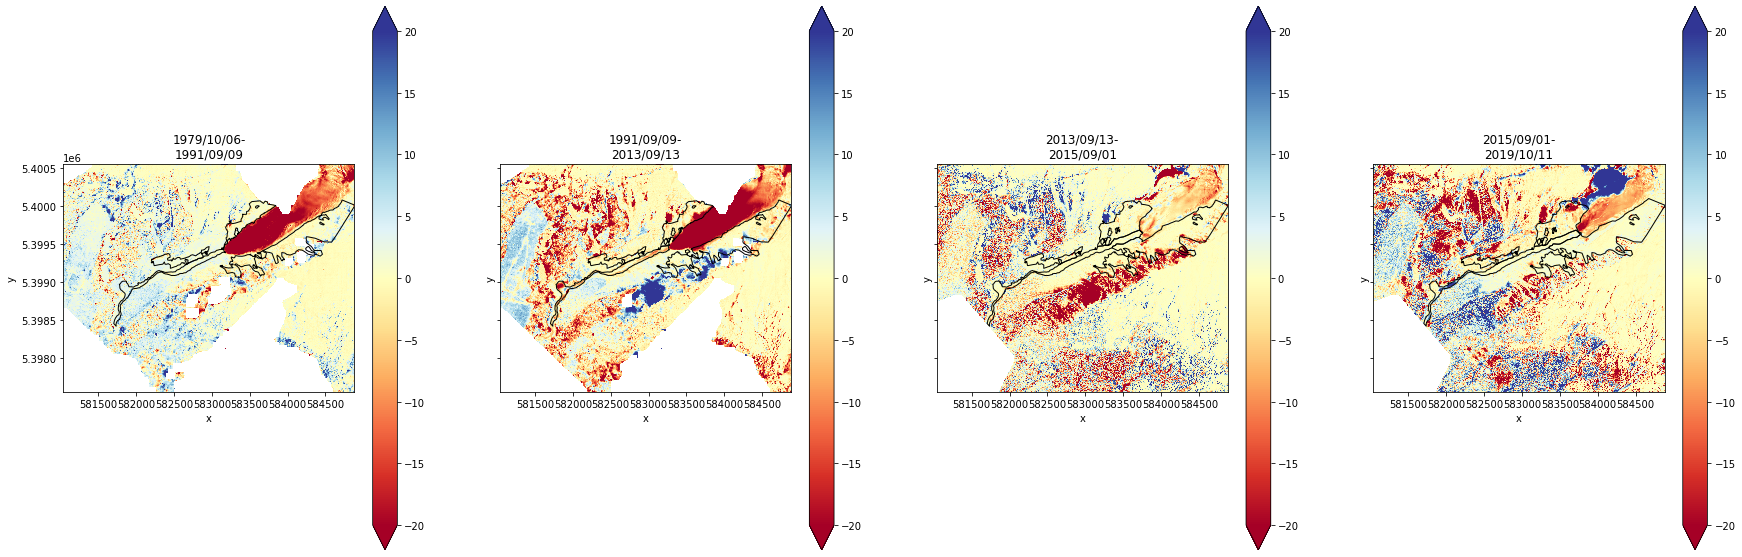

In [39]:
fig, axes = demcollection.plot_ddems(figsize=(30, 10), vmin=-20, vmax=20, plot_outlines=True)
fig.savefig(os.path.join(plot_output_dir, "dods_interpolated.png"))
plt.show()

## Save dDEMs to tif (so you can create erosion polygons now)

In [40]:
if SAVE_DDEMS:
    # Save all interval dDEMs
    os.makedirs(dods_output_path, exist_ok=True)

    for ddem in demcollection.ddems:
        startt = ddem.start_time.strftime(strip_time_format)
        endt = ddem.end_time.strftime(strip_time_format)
        fn = f"{startt}_to_{endt}_largerarea.tif"
        fn = os.path.join(dods_output_path, fn)
        print(fn)
        if INTERPOLATE:
            ddem_copy_xr = ddem.copy().to_xarray()
            ddem_copy_xr.rio.to_raster(fn.replace('.tif', '_asis.tif'))
            ddem_copy_xr.values = ddem.filled_data
            ddem_copy_xr = ddem_copy_xr.fillna(ddem_copy_xr.rio.nodata)
            ddem_copy_xr.rio.to_raster(fn)
        else:
            ddem.to_xarray().rio.to_raster(fn)

    # Save bounding dDEM

    bounding_ddem = xdem.dDEM(  
        demcollection.dems[-1] - demcollection.dems[0],
        demcollection.timestamps[0], 
        demcollection.timestamps[-1]
    )
    bounding_ddem
    filled_data = bounding_ddem.interpolate(method="linear", reference_elevation=demcollection.reference_dem, max_search_distance=50)
    bounding_ddem.data = filled_data

    startt = pd.to_datetime(bounding_ddem.start_time).strftime(strip_time_format)
    endt = pd.to_datetime(bounding_ddem.end_time).strftime(strip_time_format)
    fn = f"{startt}_to_{endt}.tif"
    fn = os.path.join(dods_output_path, fn)
    print(fn)
    bounding_ddem_copy = bounding_ddem.copy()
    bounding_ddem.to_xarray().rio.to_raster(fn)

## Mass wasting calculations

### Calculate net mass wasted

In [41]:
dv_df = demcollection.get_dv_series(return_area=True).reset_index()
dv_df.head()

option 2A
option 2A
option 2A
option 2A


,index,dh,area,volume
0,"(1979-10-06, 1991-09-09]",0.676284,660924.0,4.469722e+05
1,"(1991-09-09, 2013-09-13]",-2.013827,730620.0,-1.471342e+06
2,"(2013-09-13, 2015-09-01]",-1.199656,897916.0,-1.077190e+06
3,"(2015-09-01, 2019-10-11]",0.186642,923564.0,1.723757e+05


### Calculate net mass wasted by erosion type

In [42]:
hillslope_dv_df = demcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_dv_df['type'] = 'hillslope'
fluvial_dv_df = demcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_dv_df['type'] = 'fluvial'

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate net mass wasted with threshold (1 meter)

In [43]:
def threshold_ddem(ddem, threshold):
    ddem = ddem.copy()
    ddem.data.mask = np.logical_or(ddem.data.mask, np.abs(ddem.data.data) < threshold)
    return ddem

threshold_ddems = [threshold_ddem(ddem, 1) for ddem in demcollection.ddems]

threshold_ddemcollection = xdem.DEMCollection(
    demcollection.dems,
    demcollection.timestamps
)
threshold_ddemcollection.ddems_are_intervalwise = True
threshold_ddemcollection.ddems = threshold_ddems
threshold_ddemcollection.outlines = demcollection.outlines

In [44]:
threshold_dv_df = threshold_ddemcollection.get_dv_series(return_area=True).reset_index()

option 2A
option 2A
option 2A
option 2A


/home/elilouis/xdem/xdem/demcollection.py:281: UserWarning: NaNs found in dDEM (1979-10-06 00:00:00 - 1991-09-09 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:281: UserWarning: NaNs found in dDEM (1991-09-09 00:00:00 - 2013-09-13 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:281: UserWarning: NaNs found in dDEM (2013-09-13 00:00:00 - 2015-09-01 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")
/home/elilouis/xdem/xdem/demcollection.py:281: UserWarning: NaNs found in dDEM (2015-09-01 00:00:00 - 2019-10-11 00:00:00).
  warnings.warn(f"NaNs found in dDEM ({ddem.start_time} - {ddem.end_time}).")


### Calculate net mass wasted with threshold (1 meter), by erosion type

In [45]:
hillslope_threshold_dv_df = threshold_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_threshold_dv_df['type'] = 'hillslope'
fluvial_threshold_dv_df = threshold_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_threshold_dv_df['type'] = 'fluvial'

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate gross positive and negative mass wasted

In [46]:
def create_positive_and_negative_ddems(ddem):
    pos = ddem.copy()
    neg = ddem.copy()
    pos.data.mask = np.logical_or(pos.data.mask, pos.data.data < 0)
    neg.data.mask = np.logical_or(neg.data.mask, neg.data.data > 0)
    return pos, neg
pos_ddems, neg_ddems = zip(*[create_positive_and_negative_ddems(ddem) for ddem in demcollection.ddems])
pos_ddemcollection = xdem.DEMCollection(
    demcollection.dems,
    demcollection.timestamps
)
pos_ddemcollection.ddems_are_intervalwise = True
pos_ddemcollection.ddems = pos_ddems
pos_ddemcollection.outlines = demcollection.outlines

neg_ddemcollection = xdem.DEMCollection(
    demcollection.dems,
    demcollection.timestamps
)
neg_ddemcollection.ddems_are_intervalwise = True
neg_ddemcollection.ddems = neg_ddems
neg_ddemcollection.outlines = demcollection.outlines

In [47]:
pos_dv_df = pos_ddemcollection.get_dv_series(return_area=True).reset_index()
neg_dv_df = neg_ddemcollection.get_dv_series(return_area=True).reset_index()

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Calculate gross positive and negative mass wasted, by erosion type

In [48]:
hillslope_pos_dv_df = pos_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_pos_dv_df['type'] = 'hillslope'

fluvial_pos_dv_df = pos_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_pos_dv_df['type'] = 'fluvial'

hillslope_neg_dv_df = neg_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'hillslope'").reset_index()
hillslope_neg_dv_df['type'] = 'hillslope'

fluvial_neg_dv_df = neg_ddemcollection.get_dv_series(return_area=True, outlines_filter="type == 'fluvial'").reset_index()
fluvial_neg_dv_df['type'] = 'fluvial'

option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A
option 2A


### Add metadata to all the dataframes resulting from the calculations

Maybe this should be added as functionality to DEMCollection?

In [49]:
def enrich_volume_data(df, pixel_area, pixel_side_length, uncertainty_df):
    """Modify the resulting dataframe of `demcollection.get_dv_series` by 
    adding a bunch of useful data. Calculates volumetric uncertainty as well.

    Args:
        df (_type_): _description_
        pixel_area (_type_): _description_
    """
    df["n_pixels"] = df["area"]/pixel_area

    df["volumetric_uncertainty"] = df.apply(
        lambda row: xdem.spatialstats.volumetric_uncertainty(
            n_pixels = row["n_pixels"],
            pixel_side_length = pixel_side_length,
            rmse = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['RMSE'].iloc[0],
            mean = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Mean'].iloc[0],
            range_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Range'].iloc[0],
            sill_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Sill'].iloc[0],
        ),
        axis=1
    )
    df['start_time'] = df['index'].apply(lambda x: x.left)
    df['end_time'] = df['index'].apply(lambda x: x.right)
    df['time_difference_years'] = df.apply(
        lambda row: round((row['end_time'] - row['start_time']).days/365.25),
        axis=1
    )
    df['Annual Mass Wasted'] = df['volume']/df['time_difference_years']
    df["Upper CI"] = (df['volume'] + df['volumetric_uncertainty'])/df['time_difference_years']
    df["Lower CI"] = (df['volume'] - df['volumetric_uncertainty'])/df['time_difference_years']
    df["Average Date"] = df['start_time'] + ((df['end_time'] - df['start_time']) / 2).dt.ceil('D')
    return df

In [50]:
dv_df = enrich_volume_data(
    dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

fluvial_dv_df = enrich_volume_data(
    fluvial_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

hillslope_dv_df = enrich_volume_data(
    hillslope_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

threshold_dv_df = enrich_volume_data(
    threshold_dv_df,
    pixel_area = threshold_ddemcollection.reference_dem.res[0] * threshold_ddemcollection.reference_dem.res[1],
    pixel_side_length = threshold_ddemcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

hillslope_threshold_dv_df = enrich_volume_data(
    hillslope_threshold_dv_df,
    pixel_area = threshold_ddemcollection.reference_dem.res[0] * threshold_ddemcollection.reference_dem.res[1],
    pixel_side_length = threshold_ddemcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

fluvial_threshold_dv_df = enrich_volume_data(
    fluvial_threshold_dv_df,
    pixel_area = threshold_ddemcollection.reference_dem.res[0] * threshold_ddemcollection.reference_dem.res[1],
    pixel_side_length = threshold_ddemcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)


pos_dv_df = enrich_volume_data(
    pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

neg_dv_df = enrich_volume_data(
    neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

hillslope_pos_dv_df = enrich_volume_data(
    hillslope_pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)
fluvial_pos_dv_df = enrich_volume_data(
    fluvial_pos_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)
hillslope_neg_dv_df = enrich_volume_data(
    hillslope_neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)
fluvial_neg_dv_df = enrich_volume_data(
    fluvial_neg_dv_df,
    pixel_area = demcollection.reference_dem.res[0] * demcollection.reference_dem.res[1],
    pixel_side_length = demcollection.reference_dem.res[0], 
    uncertainty_df = uncertainty_df
)

### Plot

#### Plot net mass wasted

In [51]:
bars = alt.Chart(dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars = alt.Chart(dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

chart

alt.LayerChart(...)

#### Plot net mass wasted by erosion type

In [52]:
bars = alt.Chart(fluvial_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(fluvial_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

fluvial_chart = bars + error_bars

bars = alt.Chart(hillslope_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(hillslope_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

hillslope_chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

(fluvial_chart.properties(title='fluvial') & hillslope_chart.properties(title='hillslope')).resolve_scale(x='shared')

alt.VConcatChart(...)

In [61]:
hillslope_dv_df

,index,dh,area,volume,type,n_pixels,volumetric_uncertainty,start_time,end_time,time_difference_years,Annual Mass Wasted,Upper CI,Lower CI,Average Date
0,"(1979-10-06, 1991-09-09]",0.412494,561340.0,2.315492e+05,hillslope,140335.0,52653.651483,1979-10-06,1991-09-09,12,19295.765277,23683.569567,14907.960987,1985-09-22
1,"(1991-09-09, 2013-09-13]",-1.649881,622940.0,-1.027777e+06,hillslope,155735.0,67654.789764,1991-09-09,2013-09-13,22,-46717.128487,-43641.910770,-49792.346203,2002-09-11
2,"(2013-09-13, 2015-09-01]",-1.389440,752152.0,-1.045070e+06,hillslope,188038.0,45735.399857,2013-09-13,2015-09-01,2,-522534.885328,-499667.185400,-545402.585256,2014-09-07
3,"(2015-09-01, 2019-10-11]",-0.085845,776580.0,-6.666590e+04,hillslope,194145.0,541824.579844,2015-09-01,2019-10-11,4,-16666.473866,118789.671095,-152122.618827,2017-09-21


#### Plot QGIS zonal statistic calculations for comparison with XDEM calculations - only works when NOT erosion_by_date 

In [53]:
pixel_area_meters = 4
zonal_stats = pd.concat(map(lambda file: pd.read_csv(file), glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/qgis_zonal_statistics/*.csv")))
start_to_end_dict = {
    '1970_09_29': '1979_10_06',
    '1979_10_06': '1991_09_09',
    '1991_09_09': '2013_09_13',
    '2013_09_13': '2015_09_01',
    '2015_09_01': '2019_10_11'
}
zonal_stats['start_date'] = zonal_stats['interval']
zonal_stats['end_date'] = zonal_stats['start_date'].apply(start_to_end_dict.get)
zonal_stats['start_date'] = zonal_stats['start_date'].apply(lambda x: datetime.strptime(x, strip_time_format))
zonal_stats['end_date'] = zonal_stats['end_date'].apply(lambda x: datetime.strptime(x, strip_time_format))
zonal_stats['time_difference_years'] = zonal_stats.apply(
        lambda row: round((row['end_date'] - row['start_date']).days/365.25),
        axis=1
    )
zonal_stats['Annual Mass Wasted'] = zonal_stats['_sum']*pixel_area_meters/zonal_stats['time_difference_years']
zonal_stats = zonal_stats.groupby(['start_date', 'end_date', 'type']).sum().reset_index()
zonal_stats

,start_date,end_date,type,fid,_count,_sum,_mean,time_difference_years,Annual Mass Wasted
0,1970-09-29,1979-10-06,fluvial,1,13876,34721.524902,2.502272,9,15431.788845
1,1970-09-29,1979-10-06,hillslope,5,124366,96314.677490,2.068707,18,42806.523329
2,1979-10-06,1991-09-09,fluvial,4,13315,17366.627930,1.304290,12,5788.875977
3,1979-10-06,1991-09-09,hillslope,11,85811,14435.227539,1.357209,24,4811.742513
4,1991-09-09,2013-09-13,fluvial,7,15345,-47400.212000,-3.088968,22,-8618.220364
5,1991-09-09,2013-09-13,hillslope,17,105253,-251379.326956,-4.522618,44,-45705.332174
6,2013-09-13,2015-09-01,fluvial,10,25929,2030.426726,0.078307,2,4060.853453
7,2013-09-13,2015-09-01,hillslope,23,188043,-249679.468390,-1.077959,4,-499358.936780
8,2015-09-01,2019-10-11,fluvial,13,26226,15483.896317,0.590403,4,15483.896317
9,2015-09-01,2019-10-11,hillslope,29,194166,-43066.614421,1.071870,8,-43066.614421


In [54]:

alt.Chart(zonal_stats).mark_bar(
    strokeWidth = 3,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_date:T'),
    alt.X2('end_date:T'),
    alt.Y("Annual Mass Wasted:Q"),
).properties(
    width=300, 
    height=150,
    title="Test comparison data: QGIS zonal statistics calculations"
).facet('type:N', columns=1).resolve_scale(
    y='independent'
)

alt.FacetChart(...)

#### Plot net mass wasted, thresholded

In [55]:
bars = alt.Chart(threshold_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars = alt.Chart(threshold_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

chart

alt.LayerChart(...)

#### Plot net mass wasted by erosion type, thresholded

In [56]:
bars = alt.Chart(fluvial_threshold_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(fluvial_threshold_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

fluvial_chart = bars + error_bars

bars = alt.Chart(hillslope_threshold_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    opacity=0.8
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    width=300, 
    height=150
)

error_bars = alt.Chart(hillslope_threshold_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
).properties(
    width=300, 
    height=150
)

hillslope_chart = bars + error_bars

# chart.save(os.path.join(plot_output_dir, "mass_wasted_net.png"), scale_factor=2.0)

(fluvial_chart.properties(title='fluvial') & hillslope_chart.properties(title='hillslope')).resolve_scale(x='shared')

alt.VConcatChart(...)

#### Plot gross positive and negative mass wasted

In [57]:
bars_neg = alt.Chart(neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart = (bars_pos + error_bars_pos + bars_neg + error_bars_neg)
# chart.save(os.path.join(plot_output_dir, "mass_wasted_gross.png"), scale_factor=2.0)
chart

alt.LayerChart(...)

#### Plot gross positive and negative mass wasted, by erosion type

In [58]:
bars_neg = alt.Chart(fluvial_neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(fluvial_neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(fluvial_pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(fluvial_pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart_fluvial = (bars_pos + error_bars_pos + bars_neg + error_bars_neg).properties(title='fluvial')

In [59]:
bars_neg = alt.Chart(hillslope_neg_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
    color="red"
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_neg = alt.Chart(hillslope_neg_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

bars_pos = alt.Chart(hillslope_pos_dv_df.drop(columns='index')).mark_bar(
    strokeWidth = 3,
    stroke="white",
).encode(
    alt.X('start_time:T'),
    alt.X2('end_time:T'),
    alt.Y("Annual Mass Wasted:Q")
).properties(
    # width=300, 
    # height=300
)

error_bars_pos = alt.Chart(hillslope_pos_dv_df.drop(columns="index")).mark_bar(
    color="black",
    width=2
).encode(
    alt.X("Average Date:T"),
    alt.Y("Lower CI"),
    alt.Y2("Upper CI")
)

chart_hillslope = (bars_pos + error_bars_pos + bars_neg + error_bars_neg).properties(title='hillslope')

In [60]:
chart_fluvial & chart_hillslope

alt.VConcatChart(...)